# Stock Prices Multivariate LSTM

[Multivariate LSTM, Machine Learning Mastery](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)


In [50]:
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime as dt
import requests
import json

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Load yahoo data
target = 'AMZN'
indexes = ['IAU', 'BNDX', 'SPY', 'VIXY', 'VGK', 'VNQ', 'VOO', 'VSS', 'VT', 'OIL', 'VWO', '^N225']
companies = ['AAPL', 'FB', 'NFLX', 'TSLA', 'MSFT']
companies.append(target)
tickers = indexes + companies

start = dt.datetime(2014,1,1)
end = dt.datetime.now()
prediction_days = 60

data = pdr.DataReader(tickers, 'yahoo', start, end)
data = data['Close'].dropna()
data.head()

Symbols,IAU,BNDX,SPY,VIXY,VGK,VNQ,VOO,VSS,VT,OIL,VWO,^N225,AAPL,FB,NFLX,TSLA,MSFT,AMZN
Date,,,,,,,,,,,,,,,,,,
2014-01-06,12.01,49.720001,182.360001,571.200012,57.610001,65.260002,167.059998,102.370003,58.419998,42.220001,39.270000,15908.879883,19.426071,57.200001,51.367142,29.400000,36.130001,393.630005
2014-01-07,11.95,49.840000,183.479996,558.599976,58.000000,65.550003,168.100006,102.660004,58.689999,42.220001,39.430000,15814.370117,19.287144,57.919998,48.500000,29.872000,36.410000,398.029999
2014-01-08,11.89,49.720001,183.520004,559.599976,57.970001,65.230003,168.169998,102.639999,58.700001,39.810001,39.360001,16121.450195,19.409286,58.230000,48.712856,30.256001,35.759998,401.920013
2014-01-09,11.92,49.759998,183.639999,560.599976,58.020000,65.230003,168.270004,102.440002,58.689999,39.810001,39.110001,15880.330078,19.161428,57.220001,48.150002,29.506001,35.529999,401.010010
2014-01-10,12.09,49.889999,184.139999,547.400024,58.590000,66.120003,168.660004,103.820000,59.090000,39.810001,39.869999,15912.059570,19.033571,57.939999,47.448570,29.143999,36.040001,397.660004


In [ ]:
# Load fred data

!pip install fredapi
from fredapi import Fred

fred = Fred(api_key='1200efa1d4a1d7803f37bbd760977ddc')

T10Y2Y = fred.get_series('T10Y2Y', observation_start=start, observation_end=end) # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity
T10Y2Y = T10Y2Y.to_frame()
T10Y2Y.columns = ['T10Y2Y']

T10YIE = fred.get_series('T10YIE', observation_start=start, observation_end=end) # 10-Year Breakeven Inflation Rate
T10YIE = T10YIE.to_frame()
T10YIE.columns = ['T10YIE']

T5YIE = fred.get_series('T5YIE', observation_start=start, observation_end=end) # 5-Year Breakeven Inflation Rate
T5YIE = T5YIE.to_frame()
T5YIE.columns = ['T5YIE']

T5YIFR = fred.get_series('T5YIFR', observation_start=start, observation_end=end) # 5-Year, 5-Year Forward Inflation Expectation Rate
T5YIFR = T5YIFR.to_frame()
T5YIFR.columns = ['T5YIFR']

DJIA = fred.get_series('DJIA', observation_start=start, observation_end=end) # Dow Jones Industrial Average
DJIA = DJIA.to_frame()
DJIA.columns = ['DJIA']

NASDAQCOM = fred.get_series('NASDAQCOM', observation_start=start, observation_end=end) # NASDAQ Composite Index
NASDAQCOM = NASDAQCOM.to_frame()
NASDAQCOM.columns = ['NASDAQCOM']

data_frames = [T10Y2Y, T10YIE, T5YIE, T5YIFR, DJIA, NASDAQCOM]

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True, how='inner'), data_frames).dropna()
df_merged = df_merged.rename_axis('Date')
df_merged.tail()

,T10Y2Y,T10YIE,T5YIE,T5YIFR,DJIA,NASDAQCOM
Date,,,,,,
2021-03-03,1.33,2.21,2.45,1.97,31270.09,12997.75
2021-03-04,1.40,2.20,2.43,1.97,30924.14,12723.47
2021-03-05,1.42,2.22,2.43,2.01,31496.30,12920.15
2021-03-08,1.42,2.21,2.42,2.00,31802.44,12609.16
2021-03-09,1.38,2.21,2.41,2.01,31832.74,13073.82


In [ ]:
dfraw = df_merged.join(data)
dfraw.dropna().tail()

,T10Y2Y,T10YIE,T5YIE,T5YIFR,DJIA,NASDAQCOM,IAU,BNDX,SPY,VIXY,VGK,VNQ,VOO,VSS,VT,OIL,VWO,^N225,AAPL,FB,NFLX,TSLA,MSFT,AMZN
Date,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-03,1.33,2.21,2.45,1.97,31270.09,12997.75,16.340000,57.189999,381.420013,12.79,62.099998,86.910004,350.660004,126.849998,95.440002,17.639999,53.380001,29559.099609,122.059998,255.410004,520.700012,653.200012,227.559998,3005.000000
2021-03-04,1.40,2.20,2.43,1.97,30924.14,12723.47,16.170000,57.110001,376.700012,13.32,61.369999,85.919998,346.339996,125.730003,94.050003,18.469999,52.230000,28930.109375,120.129997,257.640015,511.290009,621.440002,226.729996,2977.570068
2021-03-05,1.42,2.22,2.43,2.01,31496.30,12920.15,16.180000,57.160000,383.630005,12.40,61.799999,86.860001,352.690002,126.129997,95.339996,19.070000,52.599998,28864.320312,121.419998,264.279999,516.390015,597.950012,231.600006,3000.459961
2021-03-08,1.42,2.21,2.42,2.00,31802.44,12609.16,16.020000,57.060001,381.720001,12.70,61.720001,87.610001,350.959991,124.970001,94.660004,18.680000,51.230000,28743.250000,116.360001,255.309998,493.329987,563.000000,227.389999,2951.949951
2021-03-09,1.38,2.21,2.41,2.01,31832.74,13073.82,16.360001,57.230000,387.170013,12.09,62.680000,88.190002,355.869995,127.000000,96.129997,18.480000,52.340000,29027.939453,121.089996,265.739990,506.440002,673.580017,233.779999,3062.850098


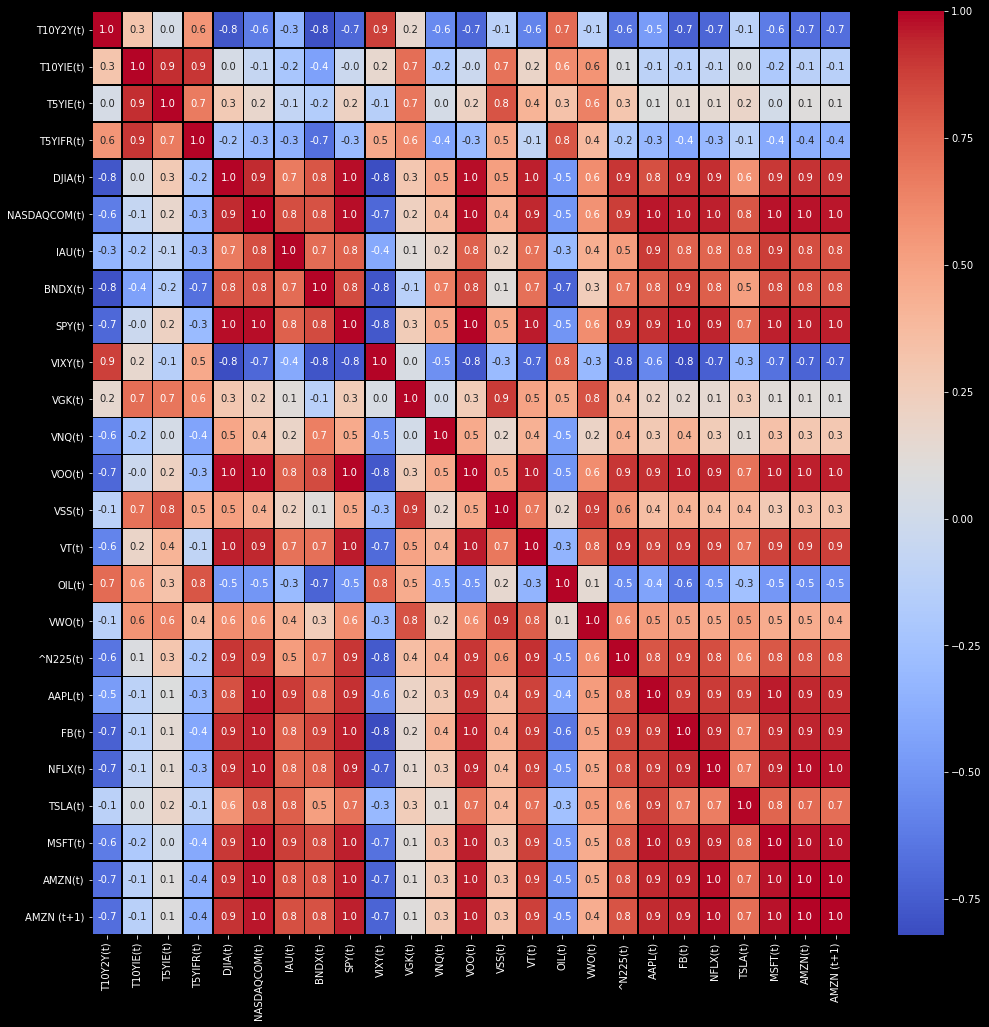

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(17, 17))
sns.heatmap(dfraw.corr(), annot=True, linewidths=0.5,linecolor="black", fmt= '.1f',ax=ax,cmap="coolwarm")
plt.show()

In [ ]:
i = 0
for n in dfraw.columns.values:
  n = str(n) + '(t)'
  dfraw.columns.values[i] = n
  i += 1

dfraw[f'{target} (t+1)'] = dfraw[target]
dfraw[f'{target} (t+1)'] = dfraw[f'{target} (t+1)'].shift(-1)
# df.columns.values[-1] = f'{company} (t+1)'
# dfraw.shape]

dfraw.tail(1)[f'{target} (t+1)'].fillna((float(0)), inplace=True)

dfraw.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,T10Y2Y(t),T10YIE(t),T5YIE(t),T5YIFR(t),DJIA(t),NASDAQCOM(t),IAU(t),BNDX(t),SPY(t),VIXY(t),VGK(t),VNQ(t),VOO(t),VSS(t),VT(t),OIL(t),VWO(t),^N225(t),AAPL(t),FB(t),NFLX(t),TSLA(t),MSFT(t),AMZN(t),AMZN (t+1)
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-03,1.33,2.21,2.45,1.97,31270.09,12997.75,16.340000,57.189999,381.420013,12.79,62.099998,86.910004,350.660004,126.849998,95.440002,17.639999,53.380001,29559.099609,122.059998,255.410004,520.700012,653.200012,227.559998,3005.000000,2977.570068
2021-03-04,1.40,2.20,2.43,1.97,30924.14,12723.47,16.170000,57.110001,376.700012,13.32,61.369999,85.919998,346.339996,125.730003,94.050003,18.469999,52.230000,28930.109375,120.129997,257.640015,511.290009,621.440002,226.729996,2977.570068,3000.459961
2021-03-05,1.42,2.22,2.43,2.01,31496.30,12920.15,16.180000,57.160000,383.630005,12.40,61.799999,86.860001,352.690002,126.129997,95.339996,19.070000,52.599998,28864.320312,121.419998,264.279999,516.390015,597.950012,231.600006,3000.459961,2951.949951
2021-03-08,1.42,2.21,2.42,2.00,31802.44,12609.16,16.020000,57.060001,381.720001,12.70,61.720001,87.610001,350.959991,124.970001,94.660004,18.680000,51.230000,28743.250000,116.360001,255.309998,493.329987,563.000000,227.389999,2951.949951,3062.850098
2021-03-09,1.38,2.21,2.41,2.01,31832.74,13073.82,16.360001,57.230000,387.170013,12.09,62.680000,88.190002,355.869995,127.000000,96.129997,18.480000,52.340000,29027.939453,121.089996,265.739990,506.440002,673.580017,233.779999,3062.850098,0.000000


In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_raw = scaler.fit_transform(dfraw.values)
scaled_data_raw[-1]

array([0.53584906, 0.94475138, 0.98268398, 0.58080808, 0.99221656,
       0.89883161, 0.64958173, 0.79052614, 0.97496223, 0.00163779,
       0.96930651, 0.73323963, 0.97428518, 0.96145117, 0.94538523,
       0.28270908, 0.85146739, 0.91304226, 0.82387774, 0.84755167,
       0.85243402, 0.75477435, 0.9464814 , 0.85557101, 0.        ])

In [ ]:
# df = df.pct_change()
df = dfraw.dropna()
df.drop(df.tail(1).index, inplace=True)
df.shape
# df.tail()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1611, 25)

In [ ]:
scaled_data = scaler.fit_transform(df.values)

# split into train and test sets
values = scaled_data
train_size = 0.8

n_train = round(df.shape[0]*train_size)

train = values[:n_train, :]
test = values[n_train:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1289, 1, 24) (1289,) (322, 1, 24) (322,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mae', optimizer='adam')

# model.save
# model.load

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/20
26/26 [==============================] - 7s 51ms/step - loss: 0.0643 - val_loss: 0.4958
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1270 - val_loss: 0.3718
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1487 - val_loss: 0.3204
Epoch 4/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0993 - val_loss: 0.0969
Epoch 5/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0614 - val_loss: 0.1412
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1031 - val_loss: 0.1308
Epoch 7/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0310 - val_loss: 0.1211
Epoch 8/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0433 - val_loss: 0.0994
Epoch 9/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0352 - val_loss: 0.0796
Epoch 10/20
26/26 [==============================] - 0s 7ms/step - loss: 0.0273 - val_loss: 0.0885
Epoch 11/20
26/26 

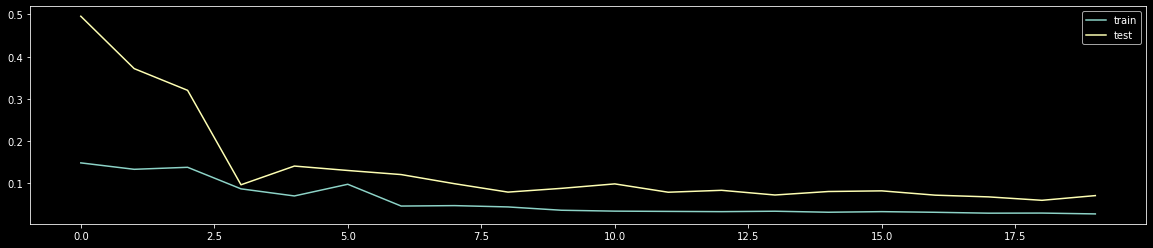

In [ ]:
# plot history
plt.style.use('dark_background')
plt.figure(figsize=(20,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape((test_X.shape[0], inv_yhat.shape[1])))
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
inv_y = concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y.reshape((inv_y.shape[0], inv_y.shape[1])))
inv_y = inv_y[:,-1]

# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.6f' % rmse)

Test RMSE: 280.878829


In [ ]:
# Output

date = df.index[df['AMZN (t+1)'] == df.values[-1][-1]].date[0] + dt.timedelta(days=1)
print('Prediction:')
print(f'{date} {target} {inv_yhat[-1]}')

Prediction:
2021-03-09 AMZN 3381.306591623241


In [ ]:
scaled_last_row = np.delete(scaled_data_raw[-1], -1)
scaled_last_row = scaled_last_row.reshape(1, 1, scaled_last_row.shape[0])

prediction = model.predict(scaled_last_row)
scaled_last_row = scaled_last_row.reshape(1, scaled_last_row.shape[2])

full_last_row = concatenate((scaled_last_row, prediction), axis=1)
full_last_row.shape
inv_prediction = scaler.inverse_transform(full_last_row)
inv_prediction = inv_prediction[:,-1]

date = dfraw.tail(1).index.date[0] + dt.timedelta(days=1)
print('Prediction:')
print(f'{date} {target} {inv_yhat[-1]}')

Prediction:
2021-03-10 AMZN 3381.306591623241


# Feature Importance

[Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

[Deep Explainer](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=deepexplainer)


 AttributeError: 'TFDeep' object has no attribute 'between_tensors'

[TFDeepExplainer broken with TF2.1.0]( https://github.com/slundberg/shap/issues/1055)

Sadly to resolve this error I should downgrade tensorflow and keras and I don't intend to do so.

In [ ]:
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=deepexplainer

!pip install shap
import shap
import tensorflow.keras.backend 
background = train_X[np.random.choice(train_X.shape[0], 100, replace=False)]# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: ignored

In [ ]:
print(train_X.shape)
print(test_X.shape)

(1289, 1, 24)
(322, 24)


In [ ]:
import shap

#train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, train_X[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_X[:10])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: ignored